<a href="https://colab.research.google.com/github/abdul-coder/crypto/blob/master/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import tensorflow as tf
from tensorflow import keras

In [51]:
tf.__version__

'2.4.0'

In [52]:
keras.__version__

'2.4.0'

In [53]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [54]:
X_train_full.shape

(60000, 28, 28)

In [55]:
X_train_full.dtype

dtype('uint8')

In [56]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [57]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

In [58]:
class_names[y_train[0]]

'Coat'

In [59]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [60]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = "sgd", 
              metrics = ["accuracy"])

In [61]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9696 - accuracy: 0.6950 - val_loss: 0.5034 - val_accuracy: 0.8320
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5034 - accuracy: 0.8255 - val_loss: 0.4454 - val_accuracy: 0.8448
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4459 - accuracy: 0.8437 - val_loss: 0.4142 - val_accuracy: 0.8568
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4107 - accuracy: 0.8563 - val_loss: 0.4060 - val_accuracy: 0.8600
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3939 - accuracy: 0.8603 - val_loss: 0.3798 - val_accuracy: 0.8686
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3745 - accuracy: 0.8670 - val_loss: 0.3765 - val_accuracy: 0.8714
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3586 - accuracy: 0.8726 - val_loss: 0.3642 - val_accuracy:

<function matplotlib.pyplot.show>

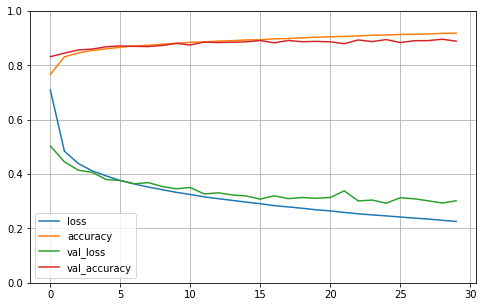

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))

plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show

In [63]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 55.4330 - accuracy: 0.8558


[55.432979583740234, 0.8557999730110168]

In [64]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [49]:
y_pred = model.predict_classes(X_new)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [65]:
y_pred

array([9, 2, 1])

In [67]:
np.array(class_names)[y_pred]

array(['Ankle Boot', 'Pullover', 'Trouser'], dtype='<U11')